# Reflector Position Optimization - Office Building Floor

This notebook implements physics-aware optimal placement for mechanical reflectors in NLOS (Non-Line-of-Sight) scenarios.

## Project Overview
- **Goal**: Find optimal deployment position for a mechanical reflector using gradient descent
- **Scenario**: Office Building Floor where direct LOS between Tx and Rx is blocked
- **Reflector Model**: Base plate with multiple tiles, each with limited rotation range (±60°)
- **Approach**: Optimize installation parameters (mount position, base orientation) considering mechanical constraints

In [ ]:
# Import Required Libraries
import tensorflow as tf
import numpy as np
import sionna
from sionna.rt import Scene, load_scene
import matplotlib.pyplot as plt
import mitsuba as mi
import drjit as dr
from sionna.rt import PlanarArray, Transmitter, Receiver, RadioMap, RadioMapSolver

print(f"TensorFlow version: {tf.__version__}")
print(f"Sionna version: {sionna.__version__}")

2026-01-19 10:24:22.895829: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-19 10:24:22.923421: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-19 10:24:23.516977: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/hieule/research/reflector-position/.venv/lib/python3.

TensorFlow version: 2.20.0
Sionna version: 1.2.1


In [10]:
# Load the scene and add Transmitter and Receiver
scene = load_scene("/home/hieule/blender/models/building_floor/building_floor.xml")
scene.frequency = 5.18e9  # 5.18 GHz
# scene.frequency = 28e9  # 28 GHz
spped_of_light = 3e8  # m/s
wavelength = spped_of_light / scene.frequency

# Add Transmitter (Tx)
scene.tx_array = PlanarArray(num_rows=2,
                        num_cols=1,
                        vertical_spacing=0.5,
                        horizontal_spacing=0.5,
                        pattern="tr38901",
                        polarization="VH"
                        )
total_power_dbm = 5.0
n_txs = 1
txs = []
for i in range(n_txs):
    # the orientation is in radians: [roll, pitch, yaw]
    # we assign different yaw angles to the transmitters so that they point in different directions equally spacedly
    tx = Transmitter(name=f"Tx{i:02d}",
                    position=[10, 20 - i * 2 * wavelength, 3.8],
                    orientation=[i * 2 * np.pi / n_txs, 0, 0],
                    power_dbm=total_power_dbm/n_txs,)
    txs.append(tx)
    scene.add(tx)
# tx00 = Transmitter(name="Tx00",
#                 position=[10, 20, 3.8],
#                 orientation=[0, 0, 0],
#                 power_dbm=total_power_dbm/n_txs,)
# tx01 = Transmitter(name="Tx01",
#                 position=[10, 20, 3.8],
#                 orientation=[np.pi/2, 0, 0],
#                 power_dbm=total_power_dbm/n_txs,)
# scene.add(tx00)
# scene.add(tx01)
# Add Receiver (Rx) - Deep in the North Leg
# Position: x=1.5, y=10, z=1.5 (user height)
scene.rx_array = PlanarArray(num_rows=2,
                        num_cols=2,
                        vertical_spacing=0.5,
                        horizontal_spacing=0.5,
                        pattern="iso",
                        polarization="VH"
                        )
rx = Receiver(name="Rx",
                position=[16, 6.5, 1.5],
                orientation=[0, 0, 0])
scene.add(rx)


# Create a Controllable Flat Reflector

Now we'll create a single flat reflector (representing a simplified version of the multi-tile reflector system). The reflector will:
1. Be movable along a wall
2. Have efficiently controllable orientation using angles (α, β, γ)
3. Use a metal material with high reflectivity

In [3]:
# Create a reflector material - highly reflective metal
reflector_material = sionna.rt.ITURadioMaterial(
    name="reflector_metal",
    itu_type="metal",
    thickness=0.002,  # 2mm thick metal plate
    # color=(0.5, 0.5, 0.55)  # Light silver color for visualization
)

# Create a flat rectangular reflector using a plane/rectangle shape
# We'll create it as a simple rectangular mesh
import numpy as np

def create_flat_reflector_mesh(width=2.0, height=2.0):
    """
    Creates a flat rectangular reflector mesh centered at origin
    
    Args:
        width: Width of reflector in meters (along y-axis)
        height: Height of reflector in meters (along z-axis)
    
    Returns:
        Mitsuba mesh object
    """
    # Define vertices for a rectangle in the y-z plane (normal along x-axis)
    # This orientation makes it easier to position along walls
    w2, h2 = width/2, height/2
    vertices = np.array([
        [-0.01, -w2, -h2],  # Bottom-left
        [-0.01,  w2, -h2],  # Bottom-right  
        [-0.01,  w2,  h2],  # Top-right
        [-0.01, -w2,  h2],  # Top-left
    ], dtype=np.float32)
    
    # Define two triangular faces (rectangle = 2 triangles)
    faces = np.array([
        [0, 1, 2],  # First triangle
        [0, 2, 3],  # Second triangle
    ], dtype=np.uint32)
    
    # Create Mitsuba mesh
    mesh = mi.Mesh(
        "reflector_mesh",
        vertex_count=len(vertices),
        face_count=len(faces),
        has_vertex_normals=False,
        has_vertex_texcoords=False
    )
    
    # Set mesh data
    mesh_params = mi.traverse(mesh)
    # Transpose vertices to shape (3, N) as required by mi.Point3f
    mesh_params['vertex_positions'] = dr.ravel(mi.Point3f(vertices.T))
    mesh_params['faces'] = dr.ravel(mi.Vector3u(faces.T))
    mesh_params.update()
    
    return mesh

# Create the reflector mesh (2m x 2m)
reflector_mesh = create_flat_reflector_mesh(width=2.0, height=2.0)

# Create SceneObject from the mesh
reflector = sionna.rt.SceneObject(
    mi_mesh=reflector_mesh,
    name="reflector",
    radio_material=reflector_material
)

# Add reflector to scene
scene.edit(add=reflector)

print(f"✓ Created flat reflector: {reflector.name}")
print(f"  - Size: 2.0m x 2.0m")
print(f"  - Material: {reflector.radio_material.name}")

✓ Created flat reflector: reflector
  - Size: 2.0m x 2.0m
  - Material: reflector_metal


## Create Helper Class for Reflector Control

Let's create a helper class that encapsulates reflector control for easier use in optimization.

In [4]:
class ReflectorController:
    """
    Helper class for controlling a flat reflector's position and orientation
    
    This class provides a convenient interface for:
    - Setting position (x, y, z) in meters
    - Setting orientation using Euler angles (α, β, γ) in radians
    - Moving along wall segments using parameter t ∈ [0, 1]
    - Orienting toward virtual targets using Law of Reflection
    - Getting/setting parameters as vectors for optimization
    """
    
    def __init__(self, reflector, wall_start=None, wall_end=None, tx_pos=None):
        """
        Args:
            reflector: sionna.rt.SceneObject representing the reflector
            wall_start: Optional starting point of wall segment (3D array)
            wall_end: Optional ending point of wall segment (3D array)
            tx_pos: Optional transmitter position (3D array)
        """
        self.reflector = reflector
        self.wall_start = wall_start
        self.wall_end = wall_end
        self.tx_pos = tx_pos
        
    def set_wall_segment(self, wall_start, wall_end):
        """Set the wall segment for constrained movement"""
        self.wall_start = np.array(wall_start, dtype=np.float32)
        self.wall_end = np.array(wall_end, dtype=np.float32)
        
    def set_tx_position(self, tx_pos):
        """Set transmitter position for orientation calculations"""
        self.tx_pos = np.array(tx_pos, dtype=np.float32)
        
    def set_position(self, x, y, z):
        """Set reflector position in meters"""
        pos = [float(x), float(y), float(z)]
        self.reflector.position = pos
        
    def get_position(self):
        """Get reflector position as numpy array. . Shape: [1, 3]"""
        return self.reflector.position
        
    def set_orientation(self, alpha, beta, gamma):
        """
        Set reflector orientation using Euler angles
        
        Args:
            alpha: Rotation around z-axis (yaw) in radians
            beta: Rotation around y-axis (pitch) in radians
            gamma: Rotation around x-axis (roll) in radians
        """
        self.reflector.orientation = [float(alpha), float(beta), float(gamma)]
        
    def get_orientation(self):
        """Get reflector orientation as numpy array [alpha, beta, gamma]. Shape: [1, 3]"""
        return self.reflector.orientation
    
    def position_along_wall(self, t):
        """
        Compute position along wall segment using parameter t
        
        Args:
            t: Position parameter in [0, 1]
        
        Returns:
            position: 3D coordinates on the wall segment
        """
        assert self.wall_start is not None and self.wall_end is not None, \
            "Wall segment not set. Call set_wall_segment() first."
        
        t_clamped = np.clip(t, 0.0, 1.0)
        position = self.wall_start + t_clamped * (self.wall_end - self.wall_start)
        return position
    
    def move_to_wall_position(self, t):
        """
        Move reflector to position defined by parameter t on wall
        
        Args:
            t: Position parameter in [0, 1]
        
        Returns:
            position: The new position coordinates
        """
        pos = self.position_along_wall(t)
        self.set_position(pos[0], pos[1], pos[2])
        return pos
    
    def compute_reflection_normal(self, virtual_target):
        """
        Compute the ideal normal vector using Law of Reflection
        
        The normal should bisect the incoming and outgoing rays.
        
        Args:
            virtual_target: Target point for reflected signal (3D array)
        
        Returns:
            normal: Unit normal vector (3D array)
            vec_in: Normalized incoming direction
            vec_out: Normalized outgoing direction
        """
        assert self.tx_pos is not None, \
            "Transmitter position not set. Call set_tx_position() first."
        
        reflector_pos = self.get_position()
        reflector_pos = np.array(reflector_pos).flatten()
        
        # Vector from reflector to Tx (incoming direction)
        vec_to_tx = self.tx_pos - reflector_pos
        vec_in = vec_to_tx / np.linalg.norm(vec_to_tx)
        
        # Vector from reflector to virtual target (outgoing direction)
        vec_to_target = virtual_target - reflector_pos
        vec_out = vec_to_target / np.linalg.norm(vec_to_target)
        
        # Ideal normal bisects incoming and outgoing rays
        normal_raw = vec_in + vec_out
        normal = normal_raw / np.linalg.norm(normal_raw)
        
        return normal, vec_in, vec_out
    
    def orient_to_target(self, virtual_target):
        """
        Orient reflector to reflect signal from Tx toward virtual target
        
        This computes the ideal normal and uses Sionna's look_at() method
        to orient the reflector, ensuring consistency with Sionna's rotation conventions.
        
        Args:
            virtual_target: Target point (3D array)
        
        Returns:
            normal: The computed normal vector
            angles: [alpha, beta, gamma] orientation angles (after look_at)
        """
        # Compute ideal normal
        normal, vec_in, vec_out = self.compute_reflection_normal(virtual_target)
        
        # Get current reflector position
        reflector_pos = self.get_position()
        reflector_pos = np.array(reflector_pos).flatten()
        
        # Create a point along the normal direction from the reflector
        # Use a distance of 3.0 meters (arbitrary, just for direction)
        target_point = reflector_pos + normal * 3
        target_point = mi.Point3f(target_point.tolist())
        print(f"target_point: {target_point}")
        
        # Use Sionna's look_at to orient the reflector toward this point
        # This ensures consistency with Sionna's internal rotation conventions
        self.reflector.look_at(target_point)
        
        # Get the resulting angles for logging/debugging
        angles = self.get_orientation()
        
        return normal, angles
    
    def set_params(self, params):
        """
        Set position and orientation from parameter vector
        
        Args:
            params: Array of [x, y, z, alpha, beta, gamma]
        """
        assert len(params) == 6, "params must have 6 elements: [x, y, z, alpha, beta, gamma]"
        self.set_position(params[0], params[1], params[2])
        self.set_orientation(params[3], params[4], params[5])
        
    def get_params(self):
        """
        Get position and orientation as parameter vector
        
        Returns:
            Array of [x, y, z, alpha, beta, gamma]
        """
        pos = self.get_position()
        orient = self.get_orientation()
        return np.concatenate([pos, orient])
    
    def __repr__(self):
        pos = self.get_position()
        orient = self.get_orientation()
        info = (f"ReflectorController(\n"
                f"  position: {np.array(pos).flatten()} m\n"
                f"  orientation: {np.degrees(orient).flatten()}\n"
                # f"  orientation: [{np.degrees(orient[0]):.1f}°, "
                # f"{np.degrees(orient[1]):.1f}°, {np.degrees(orient[2]):.1f}°]\n"
                )
        
        if self.wall_start is not None and self.wall_end is not None:
            info += (f"  wall_segment: [{self.wall_start[0]:.2f}, {self.wall_start[1]:.2f}, {self.wall_start[2]:.2f}] "
                    f"to [{self.wall_end[0]:.2f}, {self.wall_end[1]:.2f}, {self.wall_end[2]:.2f}]\n")
        
        if self.tx_pos is not None:
            info += f"  tx_position: [{self.tx_pos[0]:.2f}, {self.tx_pos[1]:.2f}, {self.tx_pos[2]:.2f}]\n"
        
        info += ")"
        return info

# Create controller for our reflector
reflector_ctrl = ReflectorController(reflector)

print("Created ReflectorController:")
print(reflector_ctrl)

# Test parameter setting
test_params = np.array([16.0, 34.5, 2.0, np.pi / 2, 0.0, 0.0])
print(f"\nSetting params: {test_params}")
reflector_ctrl.set_params(test_params)

print(f"\nAfter setting params:")
print(reflector_ctrl)

print(f"\nRetrieved params: {reflector_ctrl.get_params()}")

print("\n✓ Enhanced ReflectorController class created")
print("  - Includes wall segment movement (move_to_wall_position)")
print("  - Includes orientation control (orient_to_target)")
print("  - Includes reflection normal computation")
print("  - Ready for optimization integration")

Created ReflectorController:
ReflectorController(
  position: [-0.01  0.    0.  ] m
  orientation: [0. 0. 0.]
)

Setting params: [16.         34.5         2.          1.57079633  0.          0.        ]

After setting params:
ReflectorController(
  position: [16.  34.5  2. ] m
  orientation: [90.  0.  0.]
)

Retrieved params: [[16.       ]
 [34.5      ]
 [ 2.       ]
 [ 1.5707964]
 [ 0.       ]
 [ 0.       ]]

✓ Enhanced ReflectorController class created
  - Includes wall segment movement (move_to_wall_position)
  - Includes orientation control (orient_to_target)
  - Includes reflection normal computation
  - Ready for optimization integration


In [ ]:
# sphere_obj = sionna.rt.SceneObject(fname=sionna.rt.scene.sphere,
#                 name="sphere",
#                 radio_material=sionna.rt.ITURadioMaterial(name="sphere-material",
#                                                 itu_type="metal",
#                                                 thickness=0.01))
# sphere_obj.scale = [0.2, 0.2, 0.2]
# scene.edit(add=sphere_obj)
solver = RadioMapSolver()
rm = solver(scene, cell_size=(1., 1.), samples_per_tx=1_000_000, max_depth=15, refraction=True, diffraction=True)


In [12]:
v_max = np.max(rm.rss)
v_max = sionna.rt.utils.watt_to_dbm(v_max)
print(f"Max value in radio map: {v_max} dBm")
v_min = np.min(rm.rss)
v_min = sionna.rt.utils.watt_to_dbm(v_min)
print(f"Min value in radio map: {v_min} dBm")

Max value in radio map: -50.15986756520691 dBm
Min value in radio map: -113.77401638643039 dBm


In [ ]:
cam = sionna.rt.Camera(position=[20, 20, 50],
                       look_at=[20, 20.1, 1.5])

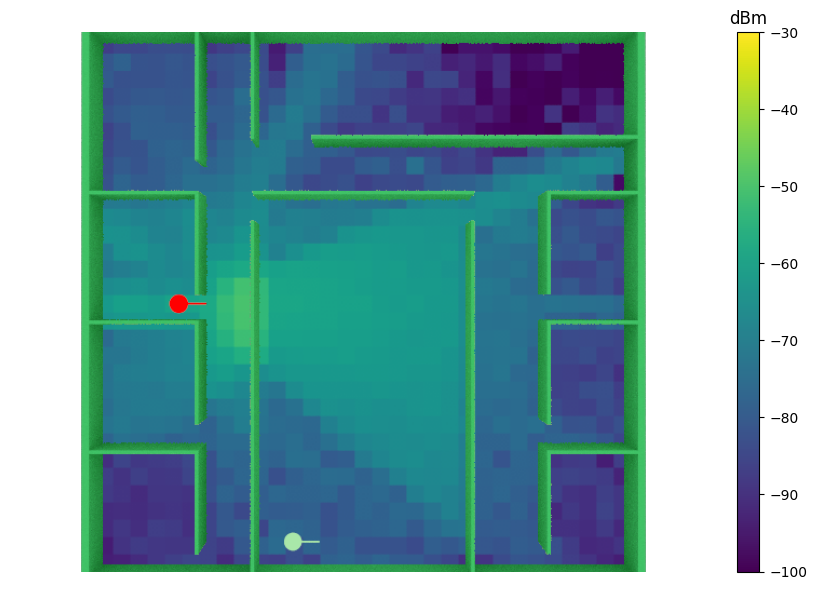

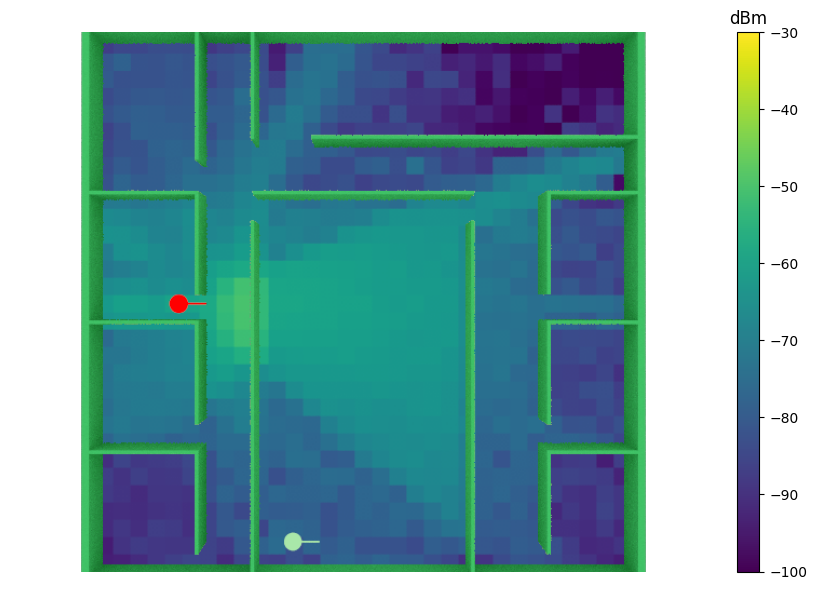

In [16]:
scene.render(camera=cam,
             radio_map=rm,
             rm_metric="rss",
             rm_vmax=-30,
             rm_vmin=-100,
            #  rm_vmax=min(-30, v_max),
            #  rm_vmin=max(-100, v_min),
             rm_db_scale=True,
             rm_show_color_bar=True,
             show_orientations=True,)


| Signal Level    | RSSI Range         | Gaming Experience on Wi-Fi 7                                                                                                                                         |
|-----------------|-------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Peak / Ultra    | -30 to -48 dBm    | Unlocked Potential: Required to activate 4096-QAM (MCS 12/13). You get maximum throughput and the lowest possible hardware latency. This effectively requires being in the same room or line-of-sight. |
| Excellent       | -49 to -60 dBm    | Competitive Ideal: Excellent for low-latency gaming. You likely drop to Wi-Fi 6 modulation (1024-QAM), but stability is perfect. This is the realistic target for high-performance gaming in a home. |
| Good / Reliable | -61 to -67 dBm    | Standard Stability: Perfectly playable for most games. Wi-Fi 7's efficiency improvements (OFDMA) help keep jitter low here, even if raw speeds drop.                 |
| Fair / Edge     | -68 to -72 dBm    | Playable but Riskier: Wi-Fi 7 manages this better than Wi-Fi 6 (maintaining higher speeds), but you are approaching the "roaming threshold" where devices might look for a new connection, causing lag spikes. |
| Poor            | -75 dBm or worse  | Not Recommended: High risk of packet loss and jitter. Wi-Fi 7 features cannot overcome the physical lack of signal power here.                                        |

In [21]:
scene.preview(radio_map=rm, rm_metric="rss", rm_vmax=-60, rm_vmin=v_min, rm_db_scale=True)

## Summary

We have successfully created a controllable flat reflector with:

1. **Position Control**: The reflector can be moved to any (x, y, z) position in the scene using the `position` property
   - Easily movable along walls or any path
   - Direct coordinate setting: `reflector.position = [x, y, z]`

2. **Orientation Control**: The reflector's orientation is controlled via three Euler angles (α, β, γ)
   - α: Rotation around z-axis (yaw)
   - β: Rotation around y-axis (pitch)  
   - γ: Rotation around x-axis (roll)
   - Direct angle setting: `reflector.orientation = [alpha, beta, gamma]`

3. **Helper Class**: Created `ReflectorController` for convenient parameter management
   - Unified 6-parameter interface: `[x, y, z, α, β, γ]`
   - Easy integration with optimization algorithms
   - `set_params()` and `get_params()` methods for vectorized operations

4. **Material Properties**: Used ITU metal material for high reflectivity

**Next Steps:**
- Create multiple tiles to form the complete reflector array
- Add mechanical constraints (±60° rotation limits per tile)
- Implement optimization objective function
- Use gradient descent to find optimal deployment parameters